<h1 style="font-weight: bold; font-size: 30px;">             Geomagnetic Storm Severity Classification</h1>


## Introduction
This notebook demonstrates loading a dataset, preprocessing, applying PCA for dimensionality reduction, training Gaussian Process Model in PyMC, Gaussian Process Model, Gaussian Naive Bayes, predict using all thes models & also evaluating performences for all these. In addition to that we did Binary calsification using Logistic Regression and Clustering with Gaussian Mixture Model using different targets under differnt notebooks to avoid library/complexity issues with PyMC. In total we used 5 models

In [2]:
!conda activate pymc3_env

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
import pymc3 as pm
import arviz as az
from sklearn.mixture import GaussianMixture
import multiprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
space_weather_df = pd.read_csv('Space_Weather.csv')
print(space_weather_df.columns)
dtype = {
    'BSRN': 'float32', 
    'ND': 'float32', 
    'KP_SUM': 'float32', 
    'AP_AVG': 'float32',
    'CP': 'float32', 
    'C9': 'float32', 
    'ISN': 'float32', 
    'F10.7_OBS': 'float32',
    'F10.7_ADJ': 'float32', 
    'F10.7_OBS_CENTER81': 'float32', 
    'F10.7_OBS_LAST81': 'float32',
    'F10.7_ADJ_CENTER81': 'float32', 
    'F10.7_ADJ_LAST81': 'float32',
    'F10.7_DATA_TYPE': 'category',
    'Geomagnetic_Storm': 'category',
    'Solar_Flare_Detection': 'int32',
    'Activity_Type': 'category'
}

space_weather_df['DATE'] = pd.to_datetime(space_weather_df['DATE'], dayfirst=True)
space_weather_df = space_weather_df.astype(dtype)


Index(['DATE', 'BSRN', 'ND', 'KP_SUM', 'AP_AVG', 'CP', 'C9', 'ISN',
       'F10.7_OBS', 'F10.7_ADJ', 'KP1', 'AP1', 'KP2', 'AP2', 'KP3', 'AP3',
       'KP4', 'AP4', 'KP5', 'AP5', 'KP6', 'AP6', 'KP7', 'AP7', 'KP8', 'AP8',
       'F10.7_OBS_CENTER81', 'F10.7_OBS_LAST81', 'F10.7_ADJ_CENTER81',
       'F10.7_ADJ_LAST81', 'F10.7_DATA_TYPE', 'Geomagnetic_Storm',
       'Solar_Flare_Detection', 'Activity_Type'],
      dtype='object')


In [3]:
# Load the dataset
space_weather_df = pd.read_csv('Space_Weather.csv')
print(space_weather_df.head())

         DATE  BSRN        ND    KP_SUM    AP_AVG        CP        C9  \
0  01-01-2000  0.42  0.462380  0.499399  0.960782  0.648720  0.144274   
1  02-01-2000  0.58  0.430591  0.932934  0.078520  0.558700  0.469506   
2  03-01-2000  0.32  0.490096  0.212742  0.281228  0.613091  0.975808   
3  04-01-2000  0.52  0.483932  0.364209  0.494099  0.887551  0.247206   
4  05-01-2000  0.64  0.253961  0.329851  0.170308  0.868245  0.703101   

        ISN   F10.7_OBS   F10.7_ADJ  ...       KP8        AP8  \
0  0.412698  104.100138  137.692459  ...  0.151015  67.191521   
1  0.349206  116.006524   95.218696  ...  2.696456   3.577513   
2  0.507937  144.873803   94.712034  ...  3.953092  57.538329   
3  0.666667  129.061898  166.211364  ...  4.916377  41.797592   
4  0.507937  150.901631  120.484369  ...  6.145471  23.716346   

   F10.7_OBS_CENTER81  F10.7_OBS_LAST81  F10.7_ADJ_CENTER81  F10.7_ADJ_LAST81  \
0          171.774873        151.169491           74.792538        169.436507   
1       

In [4]:
# Converting and encoding categorical variables for probabilistic analysis
space_weather_df['DATE'] = pd.to_datetime(space_weather_df['DATE'], format='%d-%m-%Y') 
space_weather_df['F10.7_DATA_TYPE'] = pd.Categorical(space_weather_df['F10.7_DATA_TYPE'])
space_weather_df['Geomagnetic_Storm'] = pd.Categorical(space_weather_df['Geomagnetic_Storm'])
space_weather_df['Activity_Type'] = LabelEncoder().fit_transform(space_weather_df['Activity_Type'])

In [5]:
# Defining features to normalize
features_to_normalize = ['BSRN', 'ND', 'KP_SUM', 'AP_AVG', 'CP', 'C9', 'ISN', 'F10.7_OBS', 'F10.7_ADJ']

In [6]:
# Splitting the data
X_reg = space_weather_df[features_to_normalize]
y_reg = space_weather_df['Geomagnetic_Storm'].cat.codes
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Normalizing numerical features
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

In [7]:
# Apply dimension Reduction using PCA
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_reg)
X_test_pca = pca.transform(X_test_reg)

In [ ]:
# Defining Gaussian Process Model in PyMC - with less sample size due to complexity limitations/limited resources/execution time
subset_indices = np.random.choice(X_train_pca.shape[0], size=500, replace=False)
X_train_pca_subset = X_train_pca[subset_indices, :]
y_train_reg_subset = y_train_reg.iloc[subset_indices]

with pm.Model() as gp_model:
    # Adjusting for PCA components - ℓ for each input dimension on the subset
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape=X_train_pca.shape[1])
    
    # Covariance function - Correctly specifying input_dim to match PCA components on the subset
    cov = pm.gp.cov.ExpQuad(input_dim=X_train_pca.shape[1], ls=ℓ)
    
    # GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    
    # Noise term
    σ = pm.HalfNormal("σ", sigma=1)
    
    # The observed data, corrected for shape and using the subset
    y_ = gp.marginal_likelihood("y_", X=X_train_pca, y=y_train_reg, noise=σ)
    
    # Model fitting with progress bar, adjusted for the subset
    with gp_model:
        trace = pm.sample(500, return_inferencedata=True, progressbar=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [43]:
# Extracting learned parameters from the trace
ℓ_learned = np.mean(trace.posterior['ℓ'].values)
σ_learned = np.mean(trace.posterior['σ'].values)

def eq_kernel(X1, X2, ℓ=1.0, σ_var=1.0):
    """Exponential Quadratic kernel function."""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return σ_var * np.exp(-0.5 / ℓ**2 * sqdist)

# Compute the kernel matrices
K = eq_kernel(X_train_pca_subset, X_train_pca_subset, ℓ=ℓ_learned, σ_var=1.0) + σ_learned**2 * np.eye(len(X_train_pca_subset))
K_s = eq_kernel(X_train_pca_subset, X_test_pca, ℓ=ℓ_learned, σ_var=1.0)
K_ss = eq_kernel(X_test_pca, X_test_pca, ℓ=ℓ_learned, σ_var=1.0)
K_inv = np.linalg.inv(K)

# Compute the predictive mean
mu_s = K_s.T.dot(K_inv).dot(y_train_reg_subset)

# Compute the predictive variance
var_s = np.diag(K_ss) - np.einsum('ij,jk,ki->i', K_s.T, K_inv, K_s)

# Assuming a binary classification with a threshold at 0.5
predictions = (mu_s > 0.5).astype(int)


In [44]:
# Gaussian Process Model with PyMC - Predictions 
accuracy = accuracy_score(y_test_reg, predictions)
print(f"Accuracy:", accuracy)
print(classification_report(y_test_reg, predictions))

Accuracy: 0.3177200902934537
              precision    recall  f1-score   support

           0       1.00      0.68      0.81       506
           1       0.15      1.00      0.27       219
           2       0.00      0.00      0.00      1047

    accuracy                           0.32      1772
   macro avg       0.38      0.56      0.36      1772
weighted avg       0.30      0.32      0.26      1772



In [46]:
# Gaussian Process Model not in PyMC - Predictions 
gpc = GaussianProcessClassifier().fit(X_train_pca, y_train_reg)
y_pred_gpc = gpc.predict(X_test_pca)

In [47]:
# Gaussian Naive Bayes not in PyMC - Predictions 
gnb_model = GaussianNB().fit(X_train_pca, y_train_reg)
y_pred_gnb = gnb_model.predict(X_test_pca)

      Metric  GPC - PyMC       GPC  GaussianNB
0   Accuracy    0.317720  0.911964    0.875282
1  Precision    0.304507  0.914680    0.767367
2     Recall    0.317720  0.911964    0.875282
3   F1-Score    0.263997  0.892949    0.817718


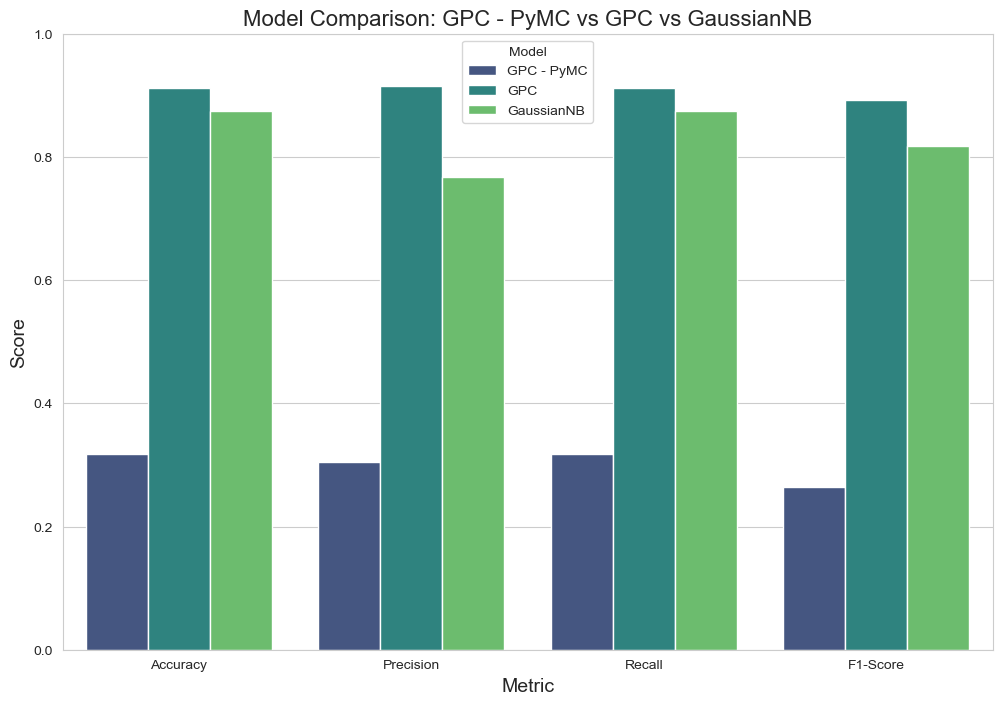

In [52]:
# Model comparison : GPC - PyMC vs GPC vs GaussianNB
metrics_gpc_pymc = precision_recall_fscore_support(y_test_reg, predictions, average='weighted')
metrics_gpc = precision_recall_fscore_support(y_test_reg, y_pred_gpc, average='weighted')
metrics_gnb = precision_recall_fscore_support(y_test_reg, y_pred_gnb, average='weighted')
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'GPC - PyMC': [accuracy_score(y_test_reg, predictions), metrics_gpc_pymc[0], metrics_gpc_pymc[1], metrics_gpc_pymc[2]],
    'GPC': [accuracy_score(y_test_reg, y_pred_gpc), metrics_gpc[0], metrics_gpc[1], metrics_gpc[2]],
    'GaussianNB': [accuracy_score(y_test_reg, y_pred_gnb), metrics_gnb[0], metrics_gnb[1], metrics_gnb[2]]
})
print(metrics_df)

# Compariosn plots 
sns.set_style("whitegrid")
metrics_melted_df = metrics_df.melt(id_vars="Metric", var_name="Model", value_name="Score")
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted_df, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Model Comparison: GPC - PyMC vs GPC vs GaussianNB', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.legend(title='Model')
plt.show()